In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [41]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [42]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [43]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [44]:
len(main_df)

775

In [45]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [46]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





In [47]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [48]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     27
2.000000     23
3.000000     11
4.000000      6
5.000000      6
             ..
0.008475      1
0.093458      1
32.716578     1
0.434164      1
0.213873      1
Name: refactoring_perc_time_taken, Length: 629, dtype: int64

In [49]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [50]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [51]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x24b95e49b00>,
 'caps': [<matplotlib.lines.Line2D at 0x24b95ddb1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24b95e49390>],
 'medians': [<matplotlib.lines.Line2D at 0x24b95e54160>],
 'fliers': [<matplotlib.lines.Line2D at 0x24b95b99390>],
 'means': []}

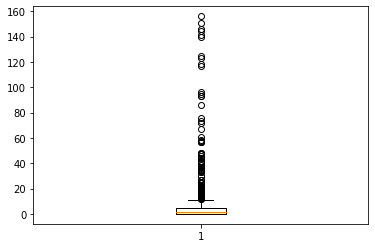

In [52]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x24b95dcb780>,
 'caps': [<matplotlib.lines.Line2D at 0x24b98ef21d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24b95dcb908>],
 'medians': [<matplotlib.lines.Line2D at 0x24b9913d128>],
 'fliers': [<matplotlib.lines.Line2D at 0x24b9913d8d0>],
 'means': []}

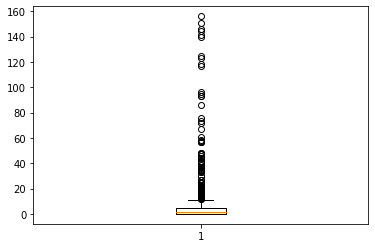

In [53]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [54]:
main_df['time_taken_final'].value_counts()

1.0     137
2.0      73
6.0      35
4.0      33
3.0      32
       ... 
0.6       1
2.4       1
1.2       1
10.6      1
32.7      1
Name: time_taken_final, Length: 119, dtype: int64

In [55]:
main_df = main_df.fillna(0)

In [56]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1,0.000000,4,1.000000,93.000000,2.06976,1.238971,-13.76,26.763600,19.4


Text(0.5, 1.0, 'Distribution of time for Refactoring Operations')

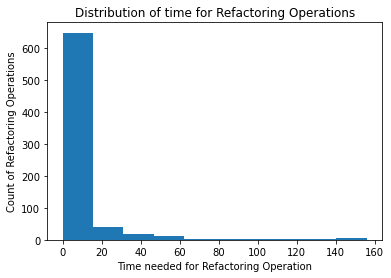

In [57]:
plt.hist(main_df['refactoring_perc_time_taken'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('Time needed for Refactoring Operation')
plt.title('Distribution of time for Refactoring Operations')

Text(0.5, 1.0, 'Distribution of ln(time) for Refactoring Operations')

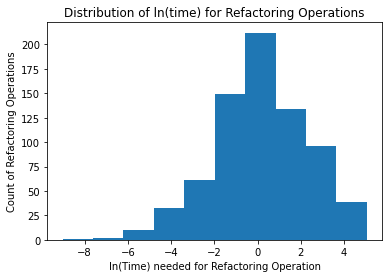

In [58]:
main_df['refactoring_perc_time_taken_log'] = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(main_df['refactoring_perc_time_taken_log'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('ln(Time) needed for Refactoring Operation')
plt.title('Distribution of ln(time) for Refactoring Operations')

In [59]:
bins = [-float('inf'),0,float('inf')]
labels = [0,1]
main_df['refactoring_perc_time_taken_bin'] = pd.cut(main_df['refactoring_perc_time_taken_log'], bins=bins, labels=pd.Categorical(labels))

(array([346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 391.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

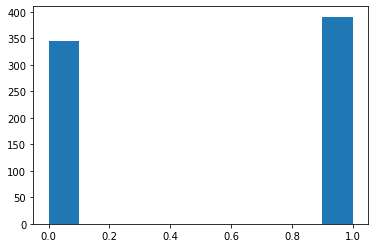

In [60]:
plt.hist(main_df['refactoring_perc_time_taken_bin'])

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  5.,  2.,  8.,
         4.,  8., 13., 12., 15., 17., 17., 28., 45., 35., 41., 36., 64.,
        48., 64., 40., 39., 34., 21., 33., 28., 21., 14., 14., 10.,  5.,
        10.]),
 array([-9.02114525, -8.66937021, -8.31759518, -7.96582015, -7.61404512,
        -7.26227009, -6.91049506, -6.55872003, -6.206945  , -5.85516996,
        -5.50339493, -5.1516199 , -4.79984487, -4.44806984, -4.09629481,
        -3.74451978, -3.39274474, -3.04096971, -2.68919468, -2.33741965,
        -1.98564462, -1.63386959, -1.28209456, -0.93031953, -0.57854449,
        -0.22676946,  0.12500557,  0.4767806 ,  0.82855563,  1.18033066,
         1.53210569,  1.88388073,  2.23565576,  2.58743079,  2.93920582,
         3.29098085,  3.64275588,  3.99453091,  4.34630594,  4.69808098,
         5.04985601]),
 <a list of 40 Patch objects>)

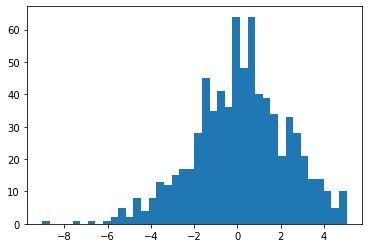

In [61]:
plt.hist(main_df['refactoring_perc_time_taken_log'],bins=40)

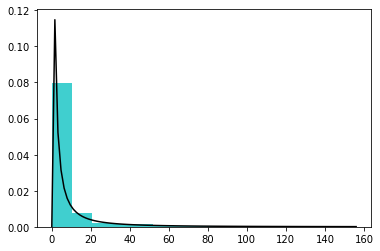

In [62]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

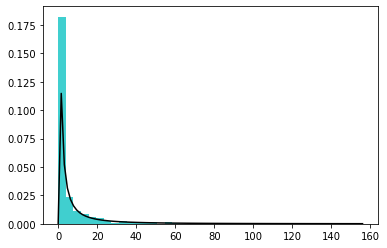

In [63]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

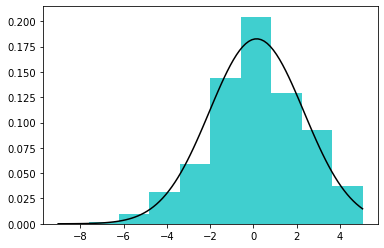

In [64]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [65]:
len(main_df)

737

In [66]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [67]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [68]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [69]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
# 'cocomoII_time_taken',
#'geneticP_time_taken',
#'softwareMaintenance_time_taken',
#'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [70]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [71]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_log')
Y_col = ['refactoring_perc_time_taken_log']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [72]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,refactoring_perc_time_taken_bin
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,17.0,17.0,0.000000,85.000000,61.000000,4.13952,2.477916,12.48,42.435515,1
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,17.0,17.0,0.000000,3.000000,78.000000,179.03424,107.076009,2229.76,519.589347,0
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,1.0,1.0,0.000000,78.000000,322.000000,18.11040,10.840124,189.60,113.234791,0
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,1.0,1.0,0.000000,57.583333,222.666667,100.38336,60.060503,1232.64,353.641141,1
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,1.0,17.0,8.238858,54.333333,88.000000,1002.79872,597.273303,12673.28,1634.048307,0


In [73]:
y.head()

,refactoring_perc_time_taken_log
0,2.708050
1,-1.489730
2,0.000000
3,1.311393
4,-4.391358


## Feature Engineering

In [74]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 2 hours 20 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,6 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_tanji_qt6nn3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.946 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [75]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = final_col
y = "refactoring_perc_time_taken_bin"
#x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [76]:
full.shape

(737, 168)

In [77]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [78]:
train[y].types

{'refactoring_perc_time_taken_bin': 'int'}

In [84]:
model_path = "models/EffortEstimationModelv3Classification/Binary_Log_GBM_grid__1_AutoML_20220228_220926_model_4"
model = h2o.load_model(model_path)

In [85]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20220228_220926_model_4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,6997.0,4.0,4.0,4.0,9.0,16.0,13.966666




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1233549801426895
RMSE: 0.3512192764395051
LogLoss: 0.41694920269194297
Mean Per-Class Error: 0.06641914191419152
AUC: 0.9785081873571974
AUCPR: 0.9711421535597238
Gini: 0.9570163747143947

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3830830513114964: 


,,0,1,Error,Rate
0,0,286.0,26.0,0.0833,(26.0/312.0)
1,1,10.0,192.0,0.0495,(10.0/202.0)
2,Total,296.0,218.0,0.07,(36.0/514.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.383083,0.914286,185.0
1,max f2,0.370994,0.936293,194.0
2,max f0point5,0.466593,0.927711,137.0
3,max accuracy,0.383083,0.929961,185.0
4,max precision,0.824382,1.000000,0.0
5,max recall,0.275415,1.000000,278.0
6,max specificity,0.824382,1.000000,0.0
7,max absolute_mcc,0.383083,0.856996,185.0
8,max min_per_class_accuracy,0.400382,0.920792,176.0
9,max mean_per_class_accuracy,0.383083,0.933581,185.0



Gains/Lift Table: Avg response rate: 39.30 %, avg score: 39.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011673,0.808400,2.544554,2.544554,1.000000,0.816395,1.000000,0.816395,0.029703,0.029703,154.455446,154.455446,0.029703
1,2,0.021401,0.777849,2.544554,2.544554,1.000000,0.784233,1.000000,0.801776,0.024752,0.054455,154.455446,154.455446,0.054455
2,3,0.031128,0.763570,2.544554,2.544554,1.000000,0.769504,1.000000,0.791691,0.024752,0.079208,154.455446,154.455446,0.079208
3,4,0.040856,0.751875,2.544554,2.544554,1.000000,0.758044,1.000000,0.783680,0.024752,0.103960,154.455446,154.455446,0.103960
4,5,0.050584,0.740726,2.544554,2.544554,1.000000,0.745481,1.000000,0.776334,0.024752,0.128713,154.455446,154.455446,0.128713
5,6,0.101167,0.685935,2.544554,2.544554,1.000000,0.714002,1.000000,0.745168,0.128713,0.257426,154.455446,154.455446,0.257426
6,7,0.149805,0.633019,2.544554,2.544554,1.000000,0.657406,1.000000,0.716674,0.123762,0.381188,154.455446,154.455446,0.381188
7,8,0.200389,0.582142,2.544554,2.544554,1.000000,0.609932,1.000000,0.689729,0.128713,0.509901,154.455446,154.455446,0.509901
8,9,0.299611,0.478169,2.394875,2.494985,0.941176,0.537890,0.980519,0.639445,0.237624,0.747525,139.487478,149.498521,0.737909
9,10,0.400778,0.401542,1.663747,2.285158,0.653846,0.436701,0.898058,0.588267,0.168317,0.915842,66.374714,128.515813,0.848534




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.24952715706672535
RMSE: 0.4995269332745987
LogLoss: 0.6962461601407707
Mean Per-Class Error: 0.45688943894389444
AUC: 0.536573368875349
AUCPR: 0.42536649532945797
Gini: 0.07314673775069802

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1396723125917396: 


,,0,1,Error,Rate
0,0,11.0,301.0,0.9647,(301.0/312.0)
1,1,2.0,200.0,0.0099,(2.0/202.0)
2,Total,13.0,501.0,0.5895,(303.0/514.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.139672,0.568990,388.0
1,max f2,0.089841,0.765732,396.0
2,max f0point5,0.212028,0.459184,357.0
3,max accuracy,0.668277,0.620623,19.0
4,max precision,0.729742,0.700000,9.0
5,max recall,0.089841,1.000000,396.0
6,max specificity,0.846743,0.996795,0.0
7,max absolute_mcc,0.668277,0.115644,19.0
8,max min_per_class_accuracy,0.370248,0.541667,208.0
9,max mean_per_class_accuracy,0.370248,0.543111,208.0



Gains/Lift Table: Avg response rate: 39.30 %, avg score: 38.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011673,0.766003,1.272277,1.272277,0.500000,0.798485,0.500000,0.798485,0.014851,0.014851,27.227723,27.227723,0.005236
1,2,0.021401,0.726930,2.035644,1.619262,0.800000,0.733887,0.636364,0.769122,0.019802,0.034653,103.564356,61.926193,0.021833
2,3,0.031128,0.695021,2.035644,1.749381,0.800000,0.709998,0.687500,0.750646,0.019802,0.054455,103.564356,74.938119,0.038430
3,4,0.040856,0.667093,1.526733,1.696370,0.600000,0.681230,0.666667,0.734118,0.014851,0.069307,52.673267,69.636964,0.046871
4,5,0.050584,0.643586,0.000000,1.370145,0.000000,0.656055,0.538462,0.719106,0.000000,0.069307,-100.000000,37.014471,0.030845
5,6,0.101167,0.572886,0.782940,1.076542,0.307692,0.602336,0.423077,0.660721,0.039604,0.108911,-21.706017,7.654227,0.012757
6,7,0.149805,0.526805,0.610693,0.925293,0.240000,0.546629,0.363636,0.623678,0.029703,0.138614,-38.930693,-7.470747,-0.018437
7,8,0.200389,0.488923,1.076542,0.963472,0.423077,0.511940,0.378641,0.595472,0.054455,0.193069,7.654227,-3.652792,-0.012059
8,9,0.299611,0.435165,1.446904,1.123569,0.568627,0.462142,0.441558,0.551317,0.143564,0.336634,44.690351,12.356950,0.060993
9,10,0.400778,0.400972,1.027609,1.099346,0.403846,0.418311,0.432039,0.517743,0.103960,0.440594,2.760853,9.934634,0.065594




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.4881972,0.09887571,0.39805827,0.47572815,0.49514562,0.65048546,0.42156863
1,auc,0.5360023,0.067888275,0.5277778,0.59514636,0.5150231,0.60464203,0.43742204
2,err,0.5118028,0.09887571,0.60194176,0.52427185,0.5048544,0.34951457,0.57843137
3,err_count,52.6,10.089599,62.0,54.0,52.0,36.0,59.0
4,f0point5,0.48463267,0.059605088,0.41666666,0.5,0.5050505,0.5656109,0.43583536
5,f1,0.57521456,0.034579173,0.530303,0.6086956,0.6060606,0.5813953,0.5496183
6,f2,0.7212816,0.07116097,0.7291667,0.7777778,0.75757575,0.5980861,0.74380165
7,lift_top_group,1.256732,1.2186666,1.4305556,2.340909,0.0,2.512195,0.0
8,logloss,0.69631565,0.031310238,0.67186856,0.6838242,0.7276679,0.6661767,0.732041
9,max_per_class_error,0.77758294,0.21960732,0.9104478,0.88135594,0.8135593,0.3902439,0.8923077



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-28 22:09:42,2.398 sec,0.0,0.488416,0.670069,0.500000,0.392996,1.000000,0.607004
1,,2022-02-28 22:09:42,2.430 sec,5.0,0.456828,0.607494,0.831167,0.795577,2.544554,0.256809
2,,2022-02-28 22:09:42,2.457 sec,10.0,0.431546,0.558974,0.901085,0.872827,2.544554,0.165370
3,,2022-02-28 22:09:42,2.481 sec,15.0,0.408258,0.516085,0.935144,0.916293,2.544554,0.136187
4,,2022-02-28 22:09:42,2.504 sec,20.0,0.386571,0.477768,0.957445,0.945186,2.544554,0.107004
5,,2022-02-28 22:09:42,2.529 sec,25.0,0.371056,0.450526,0.967742,0.959005,2.544554,0.091440
6,,2022-02-28 22:09:42,2.562 sec,30.0,0.351219,0.416949,0.978508,0.971142,2.544554,0.070039



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tryCatchQty_mean,12.168987,1.000000,0.038225
1,wmc_mean,10.787152,0.886446,0.033884
2,stringLiteralsQty_max,10.034289,0.824579,0.031519
3,anonymousClassesQty_mean,9.609140,0.789642,0.030184
4,maxNestedBlocks_std,9.058545,0.744396,0.028454
5,rfc_mean,8.549164,0.702537,0.026854
6,privateFields_min,7.876137,0.647230,0.024740
7,num_line_affected_mean,7.653132,0.628905,0.024040
8,totalMethods_max,7.633980,0.627331,0.023980
9,stringLiteralsQty_std,6.542525,0.537639,0.020551



See the whole table with table.as_data_frame()


In [97]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [98]:
preds.shape

(154, 3)

In [99]:
preds.head(15)

predict,p0,p1
0,0.808256,0.191744
0,0.681092,0.318908
1,0.584921,0.415079
0,0.735117,0.264883
0,0.778939,0.221061
0,0.736984,0.263016
0,0.862605,0.137395
1,0.576223,0.423777
0,0.741693,0.258307
0,0.809545,0.190455


In [100]:
print(len(preds))
print(len(test))
test.head()

154
154


cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,refactoring_perc_time_taken_log,refactoring_perc_time_taken_bin
25,25,25,0,32,32,32,0,1,1,1,0,65,65,65,0,9,9,9,0,23,23,23,0,1,1,1,0,18,18,18,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,7,7,7,0,3,3,3,0,1,1,1,0,4,4,4,0,2,2,2,0,0,0,0,0,4,4,4,0,0,0,0,0,46,46,46,0,265,265,265,0,6,6,6,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,80,80,80,0,14,14,14,0,49,49,49,0,32,32,32,0,48,48,48,0,2,2,2,0,0,0,0,0,0,0,0,0,1,1,1,0,166,166,166,0,1025,1025,1025,0,51,321,191.97,114.805,2393.76,544.262,-0.144761,0
15,15,15,0,3,3,3,0,1,1,1,0,21,21,21,0,3,3,3,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,64,64,0,100,100,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,99,99,0,0,0,0,0,7,7,7,0,4,4,4,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,51,51,51,0,0,0,0,0,11,104,247.336,147.875,3095.68,644.161,1.56582,1
0,0,0,0,1,1,1,0,4,4,4,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,

In [101]:
preds['actual_time_taken'] = test['refactoring_perc_time_taken_log']
preds['cocomoII_time_taken'] = test['cocomoII_time_taken']
preds['geneticP_time_taken'] = test['geneticP_time_taken']
preds['softwareMaintenance_time_taken'] = test['softwareMaintenance_time_taken']
preds['fuzzy_time_taken'] = test['fuzzy_time_taken']


In [102]:
preds.head()

predict,p0,p1,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,0.808256,0.191744,-0.144761,191.97,114.805,2393.76,544.262
0,0.681092,0.318908,1.56582,247.336,147.875,3095.68,644.161
1,0.584921,0.415079,1.22223,39.3254,23.5361,458.56,189.634
0,0.735117,0.264883,2.0149,88.9997,53.2526,1088.32,326.438
0,0.778939,0.221061,-0.370219,115.389,69.0334,1422.88,387.969
0,0.736984,0.263016,2.27421,86.9299,52.0147,1062.08,321.37
0,0.862605,0.137395,2.04307,144.883,86.6659,1796.8,451.372
1,0.576223,0.423777,3.2062,149.54,89.4495,1855.84,460.969
0,0.741693,0.258307,2.67809,99.3485,59.4416,1219.52,351.212
0,0.809545,0.190455,-3.67739,1657.36,983.883,20971.7,2282.29


In [103]:
preds.types

{'predict': 'enum',
 'p0': 'real',
 'p1': 'real',
 'actual_time_taken': 'real',
 'cocomoII_time_taken': 'real',
 'geneticP_time_taken': 'real',
 'softwareMaintenance_time_taken': 'real',
 'fuzzy_time_taken': 'real'}

In [107]:
pd_preds_read_model = preds.as_data_frame()
pd_preds_read_model.head()

,predict,p0,p1,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,0,0.808256,0.191744,-0.144761,191.97024,114.805271,2393.76,544.262337
1,0,0.681092,0.318908,1.565823,247.33632,147.875178,3095.68,644.160639
2,1,0.584921,0.415079,1.222226,39.32544,23.536054,458.56,189.633767
3,0,0.735117,0.264883,2.014903,88.99968,53.252555,1088.32,326.438257
4,0,0.778939,0.221061,-0.370219,115.38912,69.033430,1422.88,387.969305


In [108]:
pd_preds_read_model['cocomoII_time_taken_ln'] = np.log(pd_preds_read_model['cocomoII_time_taken'])
pd_preds_read_model['geneticP_time_taken_ln'] = np.log(pd_preds_read_model['geneticP_time_taken'])
pd_preds_read_model['softwareMaintenance_time_taken_ln'] = np.log(pd_preds_read_model['softwareMaintenance_time_taken'])
pd_preds_read_model['fuzzy_time_taken_ln'] = np.log(pd_preds_read_model['fuzzy_time_taken'])

C:\Users\tanji\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [109]:
pd_preds_read_model.head()

,predict,p0,p1,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,cocomoII_time_taken_ln,geneticP_time_taken_ln,softwareMaintenance_time_taken_ln,fuzzy_time_taken_ln
0,0,0.808256,0.191744,-0.144761,191.97024,114.805271,2393.76,544.262337,5.257340,4.743237,7.780621,6.299431
1,0,0.681092,0.318908,1.565823,247.33632,147.875178,3095.68,644.160639,5.510749,4.996369,8.037763,6.467948
2,1,0.584921,0.415079,1.222226,39.32544,23.536054,458.56,189.633767,3.671872,3.158533,6.128091,5.245095
3,0,0.735117,0.264883,2.014903,88.99968,53.252555,1088.32,326.438257,4.488633,3.975046,6.992391,5.788241
4,0,0.778939,0.221061,-0.370219,115.38912,69.033430,1422.88,387.969305,4.748310,4.234591,7.260438,5.960926


In [114]:
bins = [-float('inf'),0,float('inf')]
labels = [0,1]
pd_preds_read_model['actual_time_taken_bin'] = pd.cut(pd_preds_read_model['actual_time_taken'], bins=bins, labels=pd.Categorical(labels))
pd_preds_read_model['cocomoII_time_taken_bin'] = pd.cut(pd_preds_read_model['cocomoII_time_taken_ln'], bins=bins, labels=pd.Categorical(labels))
pd_preds_read_model['geneticP_time_taken_bin'] = pd.cut(pd_preds_read_model['geneticP_time_taken'], bins=bins, labels=pd.Categorical(labels))
pd_preds_read_model['softwareMaintenance_time_taken_bin'] = pd.cut(pd_preds_read_model['softwareMaintenance_time_taken'], bins=bins, labels=pd.Categorical(labels))
pd_preds_read_model['fuzzy_time_taken_bin'] = pd.cut(pd_preds_read_model['fuzzy_time_taken'], bins=bins, labels=pd.Categorical(labels))

In [115]:
pd_preds_read_model.head(10)

,predict,p0,p1,actual_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,cocomoII_time_taken_ln,geneticP_time_taken_ln,softwareMaintenance_time_taken_ln,fuzzy_time_taken_ln,cocomoII_time_taken_bin,geneticP_time_taken_bin,softwareMaintenance_time_taken_bin,fuzzy_time_taken_bin,actual_time_taken_bin
0,0,0.808256,0.191744,-0.144761,191.97024,114.805271,2393.76,544.262337,5.257340,4.743237,7.780621,6.299431,1,1,1,1,0
1,0,0.681092,0.318908,1.565823,247.33632,147.875178,3095.68,644.160639,5.510749,4.996369,8.037763,6.467948,1,1,1,1,1
2,1,0.584921,0.415079,1.222226,39.32544,23.536054,458.56,189.633767,3.671872,3.158533,6.128091,5.245095,1,1,1,1,1
3,0,0.735117,0.264883,2.014903,88.99968,53.252555,1088.32,326.438257,4.488633,3.975046,6.992391,5.788241,1,1,1,1,1
4,0,0.778939,0.221061,-0.370219,115.38912,69.033430,1422.88,387.969305,4.748310,4.234591,7.260438,5.960926,1,1,1,1,0
5,0,0.736984,0.263016,2.274210,86.92992,52.014663,1062.08,321.369979,4.465102,3.951526,6.967985,5.772593,1,1,1,1,1
6,0,0.862605,0.137395,2.043074,144.88320,86.665937,1796.80,451.372113,4.975928,4.462061,7.493763,6.112292,1,1,1,1,1
7,1,0.576223,0.423777,3.206201,149.54016,89.449540,1855.84,460.968976,5.007565,4.493675,7.526093,6.133331,1,1,1,1,1
8,0,0.741693,0.258307,2.678092,99.34848,59.441631,1219.52,351.212488,4.598634,4.084995,7.106213,5.861391,1,1,1,1,1
9,0,0.809545,0.190455,-3.677394,1657.36032,983.882551,20971.68,2282.285635,7.412981,6.891507,9.950928,7.732933,1,1,1,1,0


0.6298701298701299


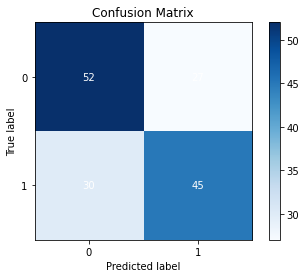

In [123]:
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score

acc = accuracy_score(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['predict'])
print(acc)

confMatrix  = confusion_matrix(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['predict'])
skplt.metrics.plot_confusion_matrix(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['predict'])

In [120]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['cocomoII_time_taken_bin'])
print(acc)

0.487012987012987


In [121]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['geneticP_time_taken_bin'])
print(acc)

0.487012987012987


In [124]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['softwareMaintenance_time_taken_bin'])
print(acc)

0.4805194805194805


In [125]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(pd_preds_read_model['actual_time_taken_bin'], pd_preds_read_model['fuzzy_time_taken_bin'])
print(acc)

0.487012987012987


In [91]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict']))
print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict'])))
print(mean_squared_error(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'],squared=False))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict']),squared=False))

print(mean_squared_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['predict_time_taken_raw_value'], squared=False))

0.2659565181450615
-0.022268789833443492
1.9671359300646738
15.381629939115845
15.381629939115845


In [92]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['cocomoII_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['cocomoII_time_taken'],squared=False))
print(mean_squared_error(pd_preds_read_model['actual_time_taken_raw_value'], pd_preds_read_model['cocomoII_time_taken'],squared=False))

-116903.00648303612
5201.570694669999
5201.570694669999


In [84]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['geneticP_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['geneticP_time_taken'],squared=False))

-21469.500146156683
2229.158187255114


In [85]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['softwareMaintenance_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['softwareMaintenance_time_taken'],squared=False))

-18786447.69865558
65938.969114608


In [86]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['fuzzy_time_taken']))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), pd_preds_read_model['fuzzy_time_taken'],squared=False))

-25722.63670019171
2439.9784539596817
